In [1]:
from pathlib import Path
import random
from uuid import uuid4

from cdp_backend.pipeline.transcript_model import Transcript
from cdp_data import CDPInstances, datasets
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

###############################################################################

random.seed(12)
np.random.seed(12)

ROUGH_MAX_CHAR_COUNT = 1024
DATASET_DIR = Path("sem-nav-cdp-sea-small-processed-chunks/")
DATASET_DIR.mkdir(exist_ok=True)
EMBEDDING_MODEL = "all-MiniLM-L12-v2"
LOADED_MODEL = SentenceTransformer(EMBEDDING_MODEL)

###############################################################################

# Get Seattle transcript data
df = datasets.get_session_dataset(
    CDPInstances.Seattle,
    start_datetime="2022-09-01",
    store_transcript=True,
    raise_on_error=False,
)

# Process each transcript
completed_chunks = []
for _, row in tqdm(df.iterrows(), desc="transcripts"):
    # Read the transcript
    with open(row.transcript_path) as open_transcript:
        t = Transcript.from_json(open_transcript.read())
    
    # Storage for the current chunk
    current_chunk_sentences = []
    current_chunk_len = 0
    current_chunk_start_time = 0
    for sentence in t.sentences:
        # If we have reached the max char count
        # store the current chunk then reset
        if current_chunk_len >= ROUGH_MAX_CHAR_COUNT:
            # Add chunk to dataset
            chunk_id = str(uuid4())
            
            # Join and store
            joined_chunk = " ".join(current_chunk_sentences)
            chunk_store_path = DATASET_DIR / f"{chunk_id}.txt"
            with open(chunk_store_path, "w") as open_text:
                open_text.write(joined_chunk)
                
            # Get the embedding for the joined_chunk
            embedding = LOADED_MODEL.encode(joined_chunk)
            
            # Add all metadata to dataset
            completed_chunks.append({
                "event_id": row.event.id,
                "start_time": current_chunk_start_time,
                "session_id": row.id,
                "session_index": row.session_index,
                "session_datetime": row.session_datetime,
                "chunk_id": chunk_id,
                "chunk_text_path": str(chunk_store_path),
                "semantic_vector": embedding,
            })
            
            # Reset the current chunk
            current_chunk_sentences = []
            current_chunk_len = 0
        
        # If no sentences in current chunk we are on a new chunk
        # Store the start time
        if current_chunk_len == 0:
            current_chunk_start_time = sentence.start_time
        
        # Append sentence to current list of chunk sentences
        current_chunk_sentences.append(sentence.text)
        current_chunk_len += len(sentence.text)

# Convert everything to a dataframe and store to parquet
dataset = pd.DataFrame(completed_chunks)
dataset.to_parquet("sem-nav-cdp-sea-small.parquet")
dataset.shape, dataset.columns

/home/eva/miniforge-pypy3/envs/sn-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching transcripts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 70.00it/s]
transcripts: 45it [01:26,  1.93s/it]


((3115, 8),
 Index(['event_id', 'start_time', 'session_id', 'session_index',
        'session_datetime', 'chunk_id', 'chunk_text_path', 'semantic_vector'],
       dtype='object'))

/home/eva/miniforge-pypy3/envs/sn-py310/lib/python3.10/site-packages/umap/plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


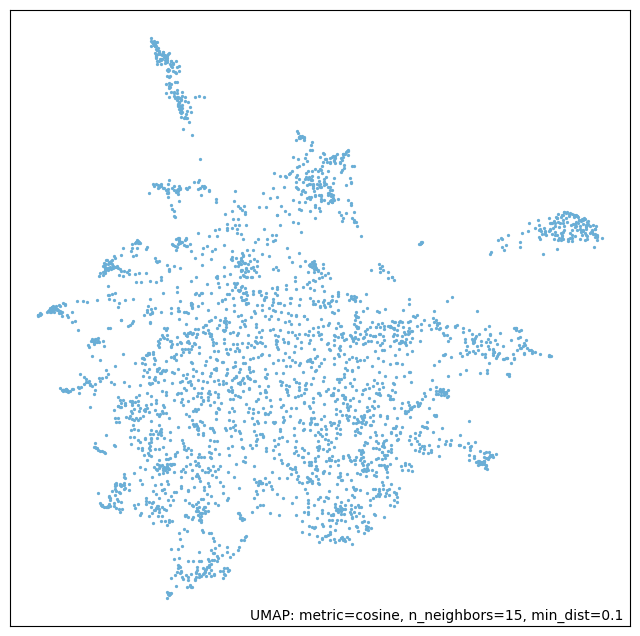

In [2]:
import umap
import umap.plot
%matplotlib inline

embedding = umap.UMAP(metric="cosine").fit(np.stack(dataset["semantic_vector"]))
umap.plot.points(embedding)